In [30]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from data_factory import holiday_dates
import os
import time

root_path = os.getcwd()
result_path = 'results/'
log_path = 'logs/'
data_path = 'data/'

In [31]:
dt_names = ['electricity_demand', 'wind_plant']

dt_name = dt_names[0]

target = 'prod'  if dt_name == 'wind_plant' else 'demand'

train_df = pd.read_csv(data_path + f'{dt_name}/train.csv', index_col=0)
future_df = pd.read_csv(data_path + f'{dt_name}/test.csv', index_col=0)

train_df['datetime'] = pd.to_datetime(train_df['datetime'])
future_df['datetime'] = pd.to_datetime(future_df['datetime'])

train_df['year'] = train_df['datetime'].dt.year.values
train_df['week'] = train_df['datetime'].dt.isocalendar().week.values
train_df['weekday'] = train_df['datetime'].dt.weekday.values
train_df['month'] = train_df['datetime'].dt.month.values
train_df['day'] = train_df['datetime'].dt.dayofyear.values
train_df['hour'] = train_df['datetime'].dt.hour.values
train_df['date'] = train_df['datetime'].dt.date

train_df['is_holiday'] = train_df['datetime'].dt.date.isin(holiday_dates).astype(float)

In [32]:
train_df.duplicated().sum()

3

In [33]:
train_df.drop_duplicates(inplace=True)
train_df.reset_index(inplace=True, drop=True)     

In [34]:

date_range = pd.date_range(train_df['datetime'].min(), train_df['datetime'].max(), freq='H')
n_missing = len(date_range) - len(train_df)

if n_missing != 0:
    print(f">>> {n_missing} records are missing, which will be filled with interpolation")
    train_df.set_index('datetime', inplace=True)
    new_df = pd.DataFrame(np.nan, index = date_range, columns = train_df.columns)
    new_df.index.name = 'datetime'
    new_df.loc[train_df.index] = train_df.values
    train_df = new_df.interpolate().reset_index()

>>> 3 records are missing, which will be filled with interpolation


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            35064 non-null  datetime64[ns]
 1   precipitation       35064 non-null  float64       
 2   temperature         35064 non-null  float64       
 3   irradiance_surface  35064 non-null  float64       
 4   irradiance_toa      35064 non-null  float64       
 5   snowfall            35064 non-null  float64       
 6   snow_mass           35064 non-null  float64       
 7   cloud_cover         35064 non-null  float64       
 8   air_density         35064 non-null  float64       
 9   demand              35064 non-null  float64       
 10  year                35064 non-null  float64       
 11  week                35064 non-null  float64       
 12  weekday             35064 non-null  float64       
 13  month               35064 non-null  float64   

In [36]:
train_df.describe()

precipitation   temperature  irradiance_surface  irradiance_toa  \
count   35064.000000  35064.000000        35064.000000    35064.000000   
mean        0.062596     11.692240          215.271874      332.143802   
std         0.095559      9.827947          288.871862      411.579754   
min         0.000000    -12.856000            0.000000        0.000000   
25%         0.003000      3.906750            0.000000        0.000000   
50%         0.023400     11.184000           18.259600       49.460300   
75%         0.081400     18.919250          406.371475      661.470600   
max         1.032700     35.953000         1024.527500     1262.921200   

           snowfall     snow_mass   cloud_cover   air_density        demand  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       0.011446      3.099654      0.360704      1.085585  28702.346306   
std        0.035165      6.858638      0.248689      0.036332   4767.001592   
min        0.000000      0.000000      0.000000      1.002400      0.000000   
25%        0.000000      0.000000      0.131300      1.056100  25009.997500   
50%        0.000000      0.006300      0.340200      1.085900  28697.645000   
75%        0.002500      2.323600      0.557000      1.113500  31883.527500   
max        0.449200     35.391200      0.986000      1.193800  45455.650000   

               year          week       weekday         month           day  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean    2015.500342     26.661875      3.003422      6.522930    183.125257   
std        1.117744     15.064325      1.999170      3.448752    105.440146   
min     2014.000000      1.000000      0.000000      1.000000      1.000000   
25%     2015.000000     14.000000      1.000000      4.000000     92.000000   
50%     2016.000000     27.000000      3.000000      7.000000    183.000000   
75%     2016.000000     40.000000      5.000000     10.000000    274.000000   
max     2017.000000     53.000000      6.000000     12.000000    366.000000   

               hour    is_holiday  
count  35064.000000  35064.000000  
mean      11.500000      0.036277  
std        6.922285      0.186980  
min        0.000000      0.000000  
25%        5.750000      0.000000  
50%       11.500000      0.000000  
75%       17.250000      0.000000  
max       23.000000      1.000000

In [37]:
train_df.corr('spearman')[target].sort_values(ascending=False)

WARNING - (py.warnings._showwarnmsg) - C:\Users\Furkan\AppData\Local\Temp\ipykernel_12560\3466633544.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




demand                1.000000
hour                  0.488556
year                  0.360576
temperature           0.162240
day                   0.063580
month                 0.061880
week                  0.059375
snow_mass             0.018398
irradiance_toa        0.010169
irradiance_surface    0.009008
snowfall              0.000209
precipitation        -0.051983
cloud_cover          -0.150599
air_density          -0.165561
is_holiday           -0.188335
weekday              -0.203028
Name: demand, dtype: float64

In [54]:
fig = px.imshow(train_df.corr('spearman'), color_continuous_scale='RdBu_r')
fig = fig.update_layout(width=800, height=600)
fig.show()

WARNING - (py.warnings._showwarnmsg) - C:\Users\Furkan\AppData\Local\Temp\ipykernel_12560\1162593268.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




In [39]:
df = train_df.groupby(['date'])[target].mean()
fig = px.line(df)
fig.update_layout(title = f'Daily Average {target}', title_x = 0.5)
fig.show()
print(f">>>> Sharply routine decreases of {target} on holidays")

>>>> Sharply routine decreases of demand on holidays


In [40]:
train_df[target+"_diff"] = train_df[target].diff(24*7)
fig = px.line(train_df, y=target+"_diff", x='datetime')
fig.update_layout(title = f'One Week Differences of {target}', title_x = 0.5)
fig.show()

In [41]:
train_df_copy = train_df.copy()
train_df_copy.loc[train_df_copy['is_holiday']==1, target] = np.nan
train_df_copy[target+"_diff"] = train_df_copy[target].diff(-24*7)

fig = px.line(train_df_copy, y=target+"_diff", x='datetime')
fig.update_layout(title = f'Dramatic Changes in {target} Except Holidays', title_x = 0.5)
fig.show()


In [42]:
df = train_df.groupby(['year', 'week'])[target].mean().unstack()
px.line(df.T)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'year=2014.0<br>week=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '2014.0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '2014.0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '616d05a8-4fe9-4c53-8073-8f063e148cf0',
              'x': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
                          15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
                          29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
                          43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.]),
              'xaxis': 'x',
              'y': array([26153.68244792, 27281.17035714, 27021.16589286, 26730.41559524,
                          26

In [43]:
fig = px.histogram(train_df, x=target, color='year', histnorm='percent')
fig.update_layout(barmode='overlay',
                 title = f"{target} Distribution",
                 title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [44]:
df = train_df.groupby(['year', 'month'])[target].mean()
df = df.unstack(0)
fig = px.line(df)
fig.update_layout(title = f'Monthly Average {target}', title_x = 0.5)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'year=2014.0<br>month=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '2014.0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '2014.0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'a33d077c-b0a4-461c-bf66-56c676f02110',
              'x': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
              'xaxis': 'x',
              'y': array([26895.1708871 , 26596.5349256 , 25473.16793683, 25422.598625  ,
                          24941.98987903, 25832.580625  , 28261.72522849, 29589.59395161,
                          27800.20191667, 23954.43885753, 26528.80255556, 27080.16983871]),
              'yaxis': 'y'},
             {'hovertemplate': 'year=2015.0<br>month=%{x}<br>value=%{y}<extra></extra>',
          

In [45]:
fig = px.violin(train_df, y=target, x='month')
fig.update_layout(barmode='overlay',
                 title = f'Monthly Distribution of {target}', title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [46]:
fig = px.violin(train_df, y=target, x='week')
fig.update_layout(barmode='overlay',
                  title = f'Weekly Distribution of {target}', title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [47]:
fig = px.violin(train_df, y=target, x='weekday')
fig.update_layout(barmode='overlay',
                    title = f'Daily Distribution of {target}', title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [48]:
fig = px.violin(train_df, y=target, x='weekday', color='year')
fig.update_layout(barmode='overlay',
                    title = f'Daily Distribution of {target}', title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [49]:
fig = px.violin(train_df, y=target, x='hour')
fig.update_layout(barmode='overlay',
                  title = f'Hourly Distribution of {target}', title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [50]:
fig = px.line(train_df.iloc[-8*30*24:-5*30*24], y=target, x='datetime')
fig.update_layout(title = f'Hourly {target}', title_x = 0.5)
fig.show()

print('>>> Dramatic change in magnitudes')

>>> Dramatic change in magnitudes


In [51]:
df = train_df[['precipitation', 'temperature', 'irradiance_surface', 'irradiance_toa', \
               'snowfall', 'snow_mass', 'cloud_cover', 'air_density','demand']].sample(1000)
fig = px.scatter_matrix(df, dimensions=df.columns)
fig.update_layout(height=1000, width=1000, font = dict(size=8))

fig.update_traces(marker=dict(size=2))
fig.show()

In [55]:
train_df_copy = train_df.copy().set_index('datetime')
decomposition = seasonal_decompose(train_df_copy[target])
decomposition_df = pd.concat((decomposition.trend, decomposition.seasonal, decomposition.resid), axis=1)

px.line(decomposition_df)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=trend<br>datetime=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'trend',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> trend <i style="color:#fc9944">~1D</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'e652982e-4cd7-4d6b-aca8-e422a8f1393c',
              'x': array([datetime.datetime(2014, 1, 1, 12, 0),
                          datetime.datetime(2014, 1, 2, 11, 0),
                          datetime.datetime(2014, 1, 3, 18, 0), ...,
                          datetime.datetime(2017, 12, 29, 17, 0),
                          datetime.datetime(2017, 12, 30, 19, 0),
                          datetime.datetime(2017, 12, 31, 11, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([22444.7991

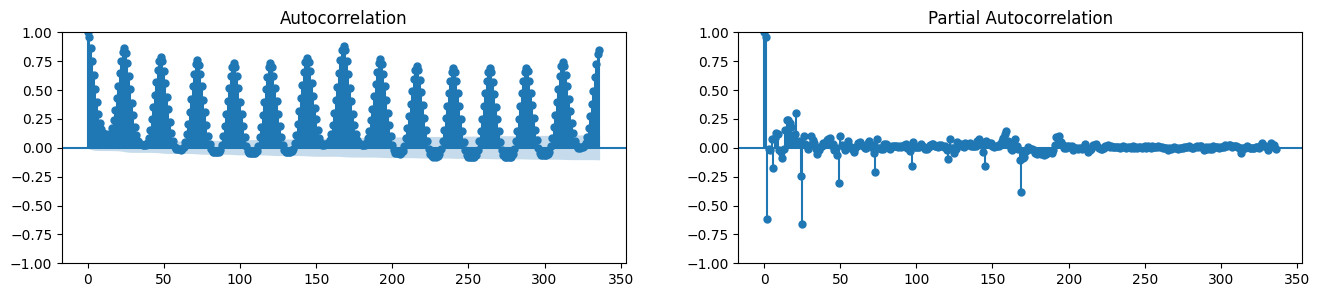

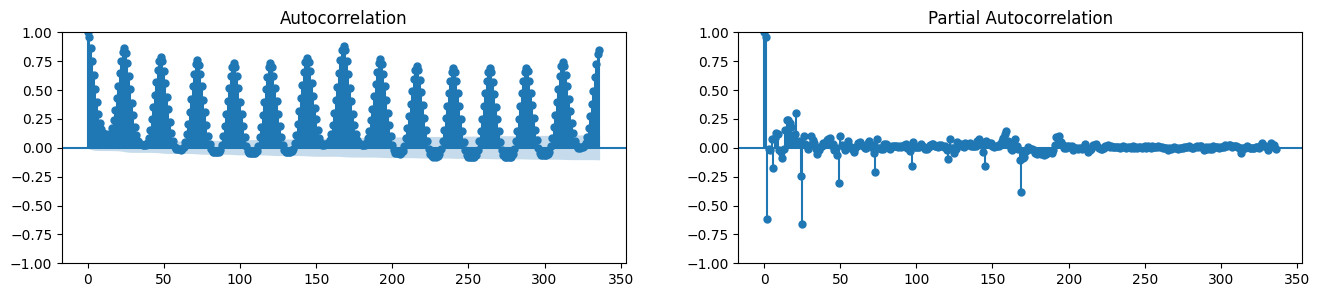

In [59]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_df[target], lags=168*2, ax=axes[0])
plot_pacf(train_df[target], lags=168*2, ax=axes[1])

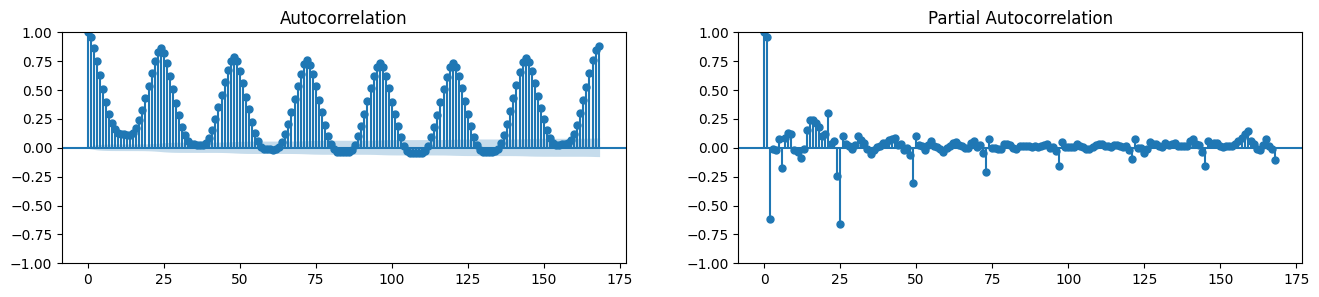

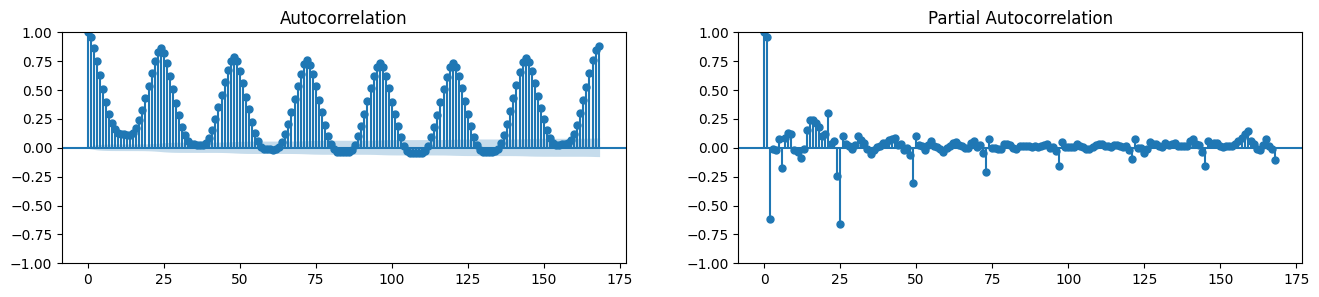

In [60]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_df[target], lags=168, ax=axes[0])
plot_pacf(train_df[target], lags=168, ax=axes[1])

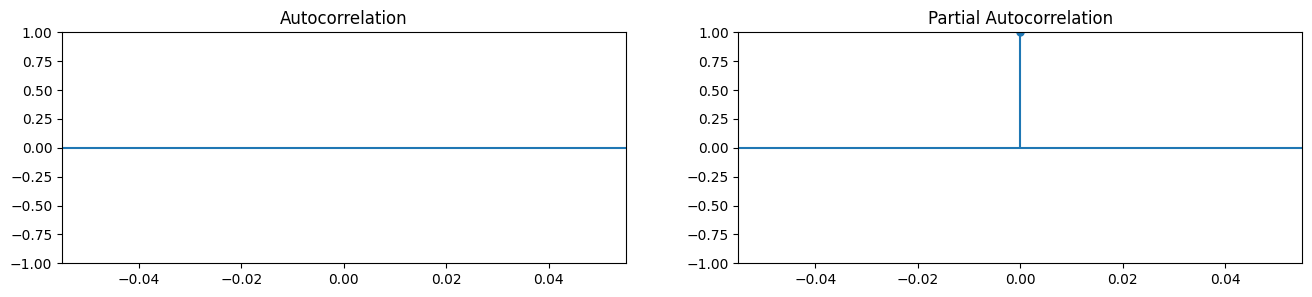

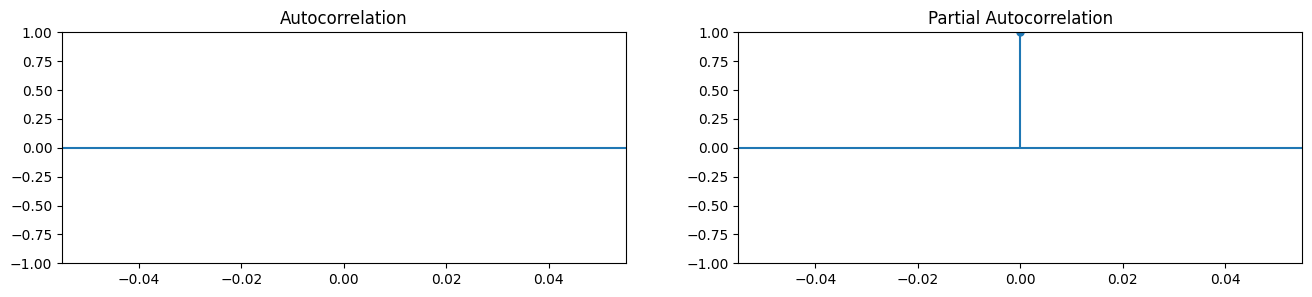

In [63]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_df[target].diff(168), lags=168, ax=axes[0])
plot_pacf(train_df[target].diff(168), lags=168, ax=axes[1])